# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'AcuteInflammations'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([120, 6]), torch.Size([120]), 120, 6, 2)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0667, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [0.0667, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [0.0833, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0833, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.1167, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [0.1167, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.1333, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000],
        [0.1833, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(72, 24, 24)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 3
m = 0.3
T = 0.1
M_train = 50
K_train = 10
M_test = 20
K_test = 10

# Aging Aware PNN

In [12]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [13]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [14]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.05)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.49396 | Loss: 0.867547214 |
| Epoch:     7 | Accuracy: 0.51500 | Loss: 0.761528492 |
| Epoch:    14 | Accuracy: 0.64708 | Loss: 0.551080048 |
| Epoch:    21 | Accuracy: 0.91500 | Loss: 0.266518891 |
| Epoch:    28 | Accuracy: 0.91708 | Loss: 0.179353863 |
| Epoch:    35 | Accuracy: 0.95354 | Loss: 0.134274378 |
| Epoch:    42 | Accuracy: 0.94729 | Loss: 0.115701154 |
| Epoch:    49 | Accuracy: 0.97688 | Loss: 0.082927644 |
| Epoch:    56 | Accuracy: 0.98583 | Loss: 0.039842661 |
| Epoch:    63 | Accuracy: 0.98667 | Loss: 0.037541263 |
| Epoch:    70 | Accuracy: 0.98354 | Loss: 0.032798093 |
| Epoch:    77 | Accuracy: 0.99771 | Loss: 0.010349529 |
| Epoch:    84 | Accuracy: 0.99708 | Loss: 0.007036958 |
| Epoch:    91 | Accuracy: 1.00000 | Loss: 0.003584011 |
| Epoch:    98 | Accuracy: 0.99542 | Loss: 0.006727159 |
| Epoch:   105 | Accuracy: 0.99875 | Loss: 0.005718660 |
| Epoch:   112 | Accuracy: 0.99771 | Loss: 0.008118996 |
| Epoch:   119 | Accuracy: 1.00

(114, 7.596656359964982e-05)

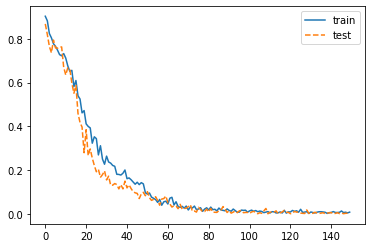

In [15]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [16]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 1.00000 | Loss: 0.002899179 |
| Epoch:    12 | Accuracy: 0.99625 | Loss: 0.006604473 |
| Epoch:    24 | Accuracy: 0.99604 | Loss: 0.005483083 |
| Epoch:    36 | Accuracy: 1.00000 | Loss: 0.000193646 |
| Epoch:    48 | Accuracy: 0.99562 | Loss: 0.008474234 |
| Epoch:    60 | Accuracy: 1.00000 | Loss: 0.000018422 |
| Epoch:    72 | Accuracy: 1.00000 | Loss: 0.000454276 |
| Epoch:    84 | Accuracy: 1.00000 | Loss: 0.001983268 |
| Epoch:    96 | Accuracy: 0.99958 | Loss: 0.000494554 |
| Epoch:   108 | Accuracy: 1.00000 | Loss: 0.000588294 |
| Epoch:   120 | Accuracy: 0.99958 | Loss: 0.002628615 |
| Epoch:   132 | Accuracy: 1.00000 | Loss: 0.000247825 |
| Epoch:   144 | Accuracy: 0.99979 | Loss: 0.003102398 |
| Epoch:   156 | Accuracy: 1.00000 | Loss: 0.000570160 |
| Epoch:   168 | Accuracy: 1.00000 | Loss: 0.001352478 |
| Epoch:   180 | Accuracy: 1.00000 | Loss: 0.000208215 |
| Epoch:   192 | Accuracy: 0.99979 | Loss: 0.002250003 |
| Epoch:   204 | Accuracy: 1.00

(56, 0.0)

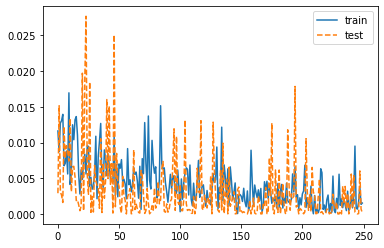

In [17]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [18]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 1.00000 | Loss: 0.003269529 |
| Epoch:    12 | Accuracy: 1.00000 | Loss: 0.000000000 |
| Epoch:    24 | Accuracy: 1.00000 | Loss: 0.001997593 |
| Epoch:    36 | Accuracy: 1.00000 | Loss: 0.001766215 |
| Epoch:    48 | Accuracy: 0.99417 | Loss: 0.012032073 |
| Epoch:    60 | Accuracy: 0.99875 | Loss: 0.009316105 |
| Epoch:    72 | Accuracy: 0.99687 | Loss: 0.008645668 |
| Epoch:    84 | Accuracy: 0.99958 | Loss: 0.004814397 |
| Epoch:    96 | Accuracy: 1.00000 | Loss: 0.002248432 |
| Epoch:   108 | Accuracy: 1.00000 | Loss: 0.001366988 |
| Epoch:   120 | Accuracy: 1.00000 | Loss: 0.001461695 |
| Epoch:   132 | Accuracy: 1.00000 | Loss: 0.001321321 |
| Epoch:   144 | Accuracy: 1.00000 | Loss: 0.000154529 |
| Epoch:   156 | Accuracy: 0.99854 | Loss: 0.006583225 |
| Epoch:   168 | Accuracy: 0.99979 | Loss: 0.001462094 |
| Epoch:   180 | Accuracy: 1.00000 | Loss: 0.000173230 |
| Epoch:   192 | Accuracy: 0.99896 | Loss: 0.004975587 |
| Epoch:   204 | Accuracy: 0.99

(12, 0.0)

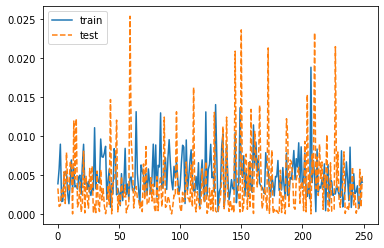

In [19]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [20]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)